# Imports

In [1]:
import random
import pandas as pd
from numpy.random import default_rng
from datetime import datetime, timedelta
import max_capacities
import numpy as np
import matplotlib.pyplot as plt
from weather_delay import simulate_random_solution
from ground_delay import ground_service

rng = default_rng(13)

# Global Variables

In [2]:
REALIZATIONS = 100
NUMBER_OF_AIRPLANES = 54
NUMBER_OF_AIRPORTS = 3

DESTINATIONS = ["Vancouver", "Toronto", "Montreal"]

TORONTO_DIST_OTHER_AIRPORTS = {
    "Vancouver": 3345,
    "Montreal": 537
}

VANCOUVER_DIST_OTHER_AIRPORTS = {
    "Toronto": 3345,
    "Montreal": 3682
}

MONTREAL_DIST_OTHER_AIRPORTS = {
    "Vancouver": 3682,
    "Toronto": 537
}

BRANDS = ["Air Canada", "West Jet", "Porter", "Flair"]
BRAND_WEIGHTS = [0.67, 0.1, 0.2, 0.03]

AIR_CANADA_MAX_CAPACITIES = max_capacities.AIR_CANADA_MAX_CAPACITIES
AIR_CANADA_WEIGHTS = max_capacities.AIR_CANADA_WEIGHTS

WEST_JET_MAX_CAPACITIES = max_capacities.WEST_JET_MAX_CAPACITIES
WEST_JET_WEIGHTS = max_capacities.WEST_JET_WEIGHTS

PORTER_MAX_CAPACITIES = max_capacities.PORTER_MAX_CAPACITIES
PORTER_WEIGHTS = max_capacities.PORTER_WEIGHTS

FLAIR_MAX_CAPACITIES = max_capacities.FLAIR_MAX_CAPACITIES
FLAIR_WEIGHTS = max_capacities.FLAIR_WEIGHTS


INCREMENT = 30
TIME = 0
END_TIME = 100000

In [3]:
flight_times_df = pd.read_csv("flight_times.csv")
montreal_capacity_df = pd.read_csv("max_capacity - YUL_capacity.csv")
vancouver_capacity_df = pd.read_csv("max_capacity - YVR_capacity.csv")
toronto_capacity_df = pd.read_csv("max_capacity - YYZ_capacity.csv")

# Class Definitions

In [4]:
class Airplane():
    def __init__(self):

        # initializing class attributes
        self.destination, self.origin = rng.choice(DESTINATIONS, 2, replace=False)
        random_arrival_time = rng.integers(0,1441*3)
        self.goal_arrival_time = random_arrival_time
        self.arrival_time = random_arrival_time
        self.departure_time = 0
        self.goal_departure_time = 0
        self.brand = rng.choice(BRANDS, 1, replace=True, p=BRAND_WEIGHTS).item()
        self.status = "flying" # Options: unallocated, flying, arriving, departing, blocked, cancelled, stalled, maintaining, landed
        self.needs_maintenance = False
        self.last_maintenance_time = 0
        self.delay = 0
        self.fullness = rng.random()
        self.cancelled_passengers = 0

        # Initializing max capacities and maintenance time
        if self.brand == "Air Canada": #todo real
            self.max_capacity = rng.choice(AIR_CANADA_MAX_CAPACITIES, 1, replace=True, p=AIR_CANADA_WEIGHTS).item()
            self.maintenance_time = rng.integers(3000, 4200)
            self.time_between_mandatory_maintenance = rng.integers(24000, 36000) #1000
            self.cleaning_time = 27
            self.threshold_time = 120
        elif self.brand == "West Jet": #todo real
            self.max_capacity = rng.choice(WEST_JET_MAX_CAPACITIES, 1, replace=True, p=WEST_JET_WEIGHTS).item()
            self.maintenance_time = rng.integers(3000, 4200)  #30
            self.time_between_mandatory_maintenance = rng.integers(24000, 36000) #1000
            self.cleaning_time = 27
            self.threshold_time = 120
        elif self.brand == "Porter": #todo real
            self.max_capacity = rng.choice(PORTER_MAX_CAPACITIES, 1, replace=True, p=PORTER_WEIGHTS).item()
            self.maintenance_time = rng.integers(3000, 4200) #60
            self.time_between_mandatory_maintenance = rng.integers(24000, 36000) #1000
            self.cleaning_time = 27
            self.threshold_time = 120
        elif self.brand == "Flair": #todo real
            self.max_capacity = rng.choice(FLAIR_MAX_CAPACITIES, 1, replace=True, p=FLAIR_WEIGHTS).item()
            self.maintenance_time = rng.integers(3000, 4200) #15
            self.time_between_mandatory_maintenance = rng.integers(24000, 36000) #1000
            self.cleaning_time = 27
            self.threshold_time = 120

    def set_destination(self):
        available_destinations = [d for d in DESTINATIONS if d != self.origin]
        self.destination = rng.choice(available_destinations)

    def reroute_destination(self):
        available_destinations = [d for d in DESTINATIONS if d != self.destination]
        self.destination = rng.choice(available_destinations)

    def delay_pseudo_agent(self):
        pass

In [5]:
class Airport():
    def __init__(self, location, distance_to_other_airports):

        # initializing class attributes
        self.location = location
        #self.pdf_delay = pdf_delay
        self.distance_to_other_airports = distance_to_other_airports
        self.congestion = 0.0
        self.delay = 0.0
        self.buffer_time = 30
        self.redirect_threshold = 100 #todo real threshold
        self.passenger_percentage = rng.random()
        #self.operation_information = operation_information
        self.delay_end_time = 0 #rng.integers(24000, 36000)

        if self.location == "Toronto":
            self.airspace_capacity = 10 
            self.airspace = self.airspace_capacity
            self.runway_capacity = 7 # 5
            self.runway_space = self.runway_capacity
            self.PASSENGER_COUNT_CONSTANT = 122739
        
        elif self.location == "Vancouver":
            self.airspace_capacity = 10 
            self.airspace = self.airspace_capacity
            self.runway_capacity = 5 # 3
            self.runway_space = self.runway_capacity
            self.PASSENGER_COUNT_CONSTANT = 68323

        elif self.location == "Montreal":
            self.airspace_capacity = 10 
            self.airspace = self.airspace_capacity
            self.runway_capacity = 4 # 2
            self.runway_space = self.runway_capacity
            self.PASSENGER_COUNT_CONSTANT = 58010

    def daily_variation_model(self, TOD):

        if self.location == "Toronto":
            return toronto_capacity_df[toronto_capacity_df['hour of day start'] == TOD]['percentage'].values[0]
            
        elif self.location == "Vancouver":
            return vancouver_capacity_df[vancouver_capacity_df['hour of day start'] == TOD]['percentage'].values[0]

        elif self.location == "Montreal":
            return montreal_capacity_df[montreal_capacity_df['hour of day start'] == TOD]['percentage'].values[0]

    def get_passenger_count(self,daily_variation):

        self.passenger_percentage = daily_variation

        """

        if self.location == "Toronto":
            sum_of_percentages = toronto_capacity_df['percentage'].sum()
            temp_constant = self.PASSENGER_COUNT_CONSTANT/sum_of_percentages
            return daily_variation * temp_constant
            
        elif self.location == "Vancouver":
            sum_of_percentages = vancouver_capacity_df['percentage'].sum()
            temp_constant = self.PASSENGER_COUNT_CONSTANT/sum_of_percentages
            return daily_variation * temp_constant

        elif self.location == "Montreal":
            sum_of_percentages = montreal_capacity_df['percentage'].sum()
            temp_constant = self.PASSENGER_COUNT_CONSTANT/sum_of_percentages
            return daily_variation * temp_constant

        """

    def get_congestion_amount(self, TOD):
        future_time = TOD + 1
        if future_time == 24:
            future_time = 0
        self.congestion = self.daily_variation_model(future_time)
    



# Weather Delay Information

In [6]:
SFO_data = {'cause': ['Wind', 'Low Ceilings', 'Low Visibility', 'Fog'], \
            'delay_probability': [0.08, 0.88, 0.03, 0.01], \
            'minutes': [14000, 4500, 5000, 12000],\
            'aircraft_numbers': [223, 95, 118, 24],\
            }

ORD_data = {'cause': ['Wind', 'Low Ceilings', 'Low Visibility', 'Rain', "Snow/ice","Thunderstorms"], \
            'delay_probability': [0.29, 0.25, 0.08, 0.06,0.14,0.15],\
            'minutes': [20000, 31000, 21000, 18000,26000,27000],\
            'aircraft_numbers': [425, 517, 373, 387,431,412],\
            }

YVR_df = pd.DataFrame(SFO_data)
YVR_df["delay_per_plane"] = YVR_df["minutes"]/YVR_df["aircraft_numbers"]
YUL_df = pd.DataFrame(ORD_data)
YUL_df["delay_per_plane"] = YUL_df["minutes"]/YUL_df["aircraft_numbers"]
YYZ_df = pd.DataFrame(ORD_data)
YYZ_df["delay_per_plane"] = YYZ_df["minutes"]/YYZ_df["aircraft_numbers"]

# Simulations

In [7]:
delay_list_per_realization = []
cancellation_delay_list_per_realization = []
airport_delay_list_per_realization = []
time_dellll = 0
num_flights = 0
for realization in range(REALIZATIONS):

    TIME = 0

    # Initializing Airplanes
    airplanes = []
    for i in range(NUMBER_OF_AIRPLANES):
        airplanes.append(Airplane())

    # Initializing Airports
    toronto_airport = Airport(location="Toronto", distance_to_other_airports=TORONTO_DIST_OTHER_AIRPORTS)
    vancouver_airport = Airport(location="Vancouver", distance_to_other_airports=VANCOUVER_DIST_OTHER_AIRPORTS)
    montreal_airport = Airport(location="Montreal", distance_to_other_airports=MONTREAL_DIST_OTHER_AIRPORTS)
    airports = [toronto_airport, vancouver_airport, montreal_airport]

    # Initializing the variables we want to track
    delay_sum = 0
    delay_list = []
    cancellations_list = []
    airport_delay_dict = {
        "Toronto": [],
        "Vancouver": [],
        "Montreal": []
    }
    while (TIME < END_TIME):

        Time_Of_Day = (TIME % 1440) // 60

        # ---------- ITERATING THROUGH AIRPORTS -------------#
        for airport in airports:
            airport_delay_dict[airport.location].append(airport.delay)

            # ------- Evaluating Models + Psuedo Agents ------#
            daily_variation = airport.daily_variation_model(Time_Of_Day)
            airport.get_passenger_count(daily_variation) # should call the daily variation. daily variation outputs num between 0 and 1. multiple by a CONSTANT
            airport.get_congestion_amount(Time_Of_Day)

            # Delay Pseudo Agent
            
            """
                Evaluate (Delay Pseudo Agent):
                    If current time < airport delay end time:
                        Update (congestion to 100%)
                    else:
                        Check (airport delay [Boolean]):
                            Update (airport delay end time)
                        for airplane departing current airport:
                            Check (airplane delay [Boolean]):
                                Update (airplane departure time)
                                Update (airplane arrival time)

            """

            # ------- Evaluating Airport Agents ------#

            # Obtaining a list of airplanes where it's destination is the current airport in the loop
            relevant_airplanes_list = [airplane for airplane in airplanes if airplane.destination == airport.location]

            # Updating runway spaces for planes that landed

            # Checking if airplanes status needs to be changed to blocked
            if airport.delay_end_time - TIME > airport.redirect_threshold:
                for airplane in relevant_airplanes_list:
                    airplane.status = "blocked"
                    airplane.cancelled_passengers += airplane.max_capacity * airplane.fullness
            else:

                # ------- Airspace Calculation ------- #
                departing_airplanes_list = [airplane for airplane in airplanes if airplane.origin == airport.location and airplane.status == "departing"]
                landed_airplanes_list = [airplane for airplane in airplanes if airplane.origin == airport.location and airplane.status == "landed"]
                num_of_landed_airplanes = len(landed_airplanes_list)
                num_of_departing_airplanes = len(departing_airplanes_list)
                arriving_airplanes_list = [airplane for airplane in relevant_airplanes_list if (airplane.status == "arriving" or airplane.status == "cancelled")]
                num_of_arriving_airplanes = len(arriving_airplanes_list)

                airport.airspace = int(max(0,airport.airspace_capacity*(1-airport.congestion)))
                airport.runway_space = int(max(0,airport.runway_capacity*(1-airport.congestion) - num_of_landed_airplanes))
                # ------- Arriving Airplanes --------#

                limiting_space = min(airport.airspace,airport.runway_space)
                #print(limiting_space,num_of_arriving_airplanes)
                if (num_of_arriving_airplanes > limiting_space):
                    for arriving_airplanes in arriving_airplanes_list[:limiting_space]:  #M3 add internal logic
                        if arriving_airplanes.status == "cancelled":
                            arriving_airplanes.cancelled_passengers += arriving_airplanes.max_capacity * arriving_airplanes.fullness
                        else:
                            time_delayed = max(0, arriving_airplanes.arrival_time - arriving_airplanes.goal_arrival_time) # ensure delay is >= 0
                            #print(time_delayed, arriving_airplanes.fullness, arriving_airplanes.max_capacity)
                            time_dellll += time_delayed
                            arriving_airplanes.delay += time_delayed * arriving_airplanes.fullness * arriving_airplanes.max_capacity # adding delay
                            airport.delay += time_delayed * arriving_airplanes.fullness * arriving_airplanes.max_capacity
                        arriving_airplanes.status = "landed"
                        arriving_airplanes.origin = airport.location
                    for arriving_airplanes in arriving_airplanes_list[limiting_space:]:  #M3 add internal logic
                        arriving_airplanes.status = "stalled"
                else:
                    for arriving_airplanes in arriving_airplanes_list:
                        if arriving_airplanes.status == "cancelled":
                            arriving_airplanes.cancelled_passengers += arriving_airplanes.max_capacity * arriving_airplanes.fullness
                        else:
                            time_delayed = max(0, arriving_airplanes.arrival_time - arriving_airplanes.goal_arrival_time) # ensure delay is >= 0
                            #print(time_delayed, arriving_airplanes.fullness, arriving_airplanes.max_capacity)
                            time_dellll += time_delayed
                            arriving_airplanes.delay += time_delayed * arriving_airplanes.fullness * arriving_airplanes.max_capacity # adding delay
                            airport.delay += time_delayed * arriving_airplanes.fullness * arriving_airplanes.max_capacity
                        arriving_airplanes.status = "landed"
                        arriving_airplanes.origin = airport.location


                # ------- Departing Airplanes ------#
                if (num_of_departing_airplanes > airport.airspace):
                    available_spots = num_of_departing_airplanes - airport.airspace
                    chosen_airplanes_to_depart = rng.choice(departing_airplanes_list, available_spots, replace=False) #M3 add internal logic
                    for airplane in chosen_airplanes_to_depart:
                        airplane.status = "flying"
                        airplane.fullness = airport.passenger_percentage

                else:
                    for airplane in departing_airplanes_list:
                        airplane.status = "flying"
                        airplane.fullness = airport.passenger_percentage
                # ----------------------------------#

        # ---------- ITERATING THROUGH AIRPLANES -------------#
        delay = []
        cancel = []
        for airplane in airplanes:
            delay.append(airplane.delay)
            cancel.append(airplane.cancelled_passengers)
            # ------- Maintenance Model ------#
            if airplane.status == "maintaining":
                airplane.goal_departure_time += airplane.maintenance_time
                airplane.departure_time += airplane.maintenance_time #todo add variance positive
                airplane.last_maintenance_time = TIME
                airplane.status = "landed"

            # ------- Evaluating Airplane Agents------#
            elif (airplane.arrival_time > airplane.time_between_mandatory_maintenance + airplane.last_maintenance_time) and (airplane.status == 'landed'):
                airplane.status = "maintaining"

            elif airplane.status == "blocked":
                airplane.reroute_destination()
                airplane.status = "flying"

            elif airplane.status == "landed" and airplane.departure_time < TIME:
                airplane.set_destination() # setting destination

                ground_delay = 0
                air_delay = 0

                if airplane.origin == "Vancouver":
                    current_airport = vancouver_airport
                    if rng.random() < 0.2:
                        air_delay += simulate_random_solution(YVR_df)["delay_per_plane"].tolist()[0]
                    ground_delay += ground_service()
                elif airplane.origin == "Toronto":
                    current_airport = toronto_airport
                    if rng.random() < 0.2:
                        air_delay += simulate_random_solution(YYZ_df)["delay_per_plane"].tolist()[0]
                    ground_delay += ground_service()
                elif airplane.origin == "Montreal":
                    current_airport = montreal_airport
                    if rng.random() < 0.2:
                        air_delay += simulate_random_solution(YUL_df)["delay_per_plane"].tolist()[0]
                    ground_delay += ground_service()

                avg_time_to_airport = flight_times_df[(flight_times_df['start_destination'] == airplane.origin) & (flight_times_df['end_destination'] == airplane.destination)]['avg_time'].iloc[0]
                current_arrival_time = airplane.arrival_time
                airplane.arrival_time = current_arrival_time + avg_time_to_airport + air_delay
                airplane.goal_arrival_time = current_arrival_time + avg_time_to_airport
                airplane.departure_time = current_arrival_time + airplane.cleaning_time + current_airport.buffer_time + ground_delay
                airplane.goal_departure_time = current_arrival_time + airplane.cleaning_time + current_airport.buffer_time
                num_flights += 1

            elif airplane.status == "stalled":
                airplane.delay += INCREMENT
                airplane.arrival_time += INCREMENT
                delay_sum += INCREMENT
                airplane.status = "arriving"

            elif airplane.arrival_time - airplane.goal_arrival_time > airplane.threshold_time:
                airplane.status = "cancelled"

            elif (TIME > airplane.departure_time) and (airplane.status == "landed"):
                airplane.status = "departing"

            elif (TIME > airplane.arrival_time):
                airplane.status = "arriving"

        delay_list.append(sum(delay))
        cancellations_list.append(sum(cancel))
        #print(delay_sum)

        TIME += INCREMENT

    delay_list_per_realization.append(delay_list)
    cancellation_delay_list_per_realization.append(cancellations_list)
    airport_delay_list_per_realization.append(airport_delay_dict)


# Creating Pandas Dataframes to Organize Data

In [8]:
# Creating the dataframe for the delay per realization
delay_per_realization_df = pd.DataFrame(delay_list_per_realization, columns=[f"increment_{increment}" for increment in list(np.arange(0, END_TIME, INCREMENT))])
# Creating the dataframe for the cancellation delay per realization
cancellation_delay_per_realization_df = pd.DataFrame(cancellation_delay_list_per_realization, columns=[f"increment_{increment}" for increment in list(np.arange(0, END_TIME, INCREMENT))])

In [9]:
# Getting the delay dataframes per City

city_delay_dfs = {}
for city in DESTINATIONS:
    temp_delay_list_per_realization = []

    for realization_dict in airport_delay_list_per_realization:
        temp_delay_list_per_realization.append(realization_dict[city])
        
    city_delay_dfs[city] = pd.DataFrame(
        temp_delay_list_per_realization, 
        columns=[f"increment_{increment}" for increment in list(np.arange(0, END_TIME, INCREMENT))]
        )

Toronto_delay_per_realization_df = city_delay_dfs["Toronto"]
Vancouver_delay_per_realization_df = city_delay_dfs['Vancouver']
Montreal_delay_per_realization_df = city_delay_dfs['Montreal']

In [10]:
delay_per_realization_df

,increment_0,increment_30,increment_60,increment_90,increment_120,increment_150,increment_180,increment_210,increment_240,increment_270,...,increment_99720,increment_99750,increment_99780,increment_99810,increment_99840,increment_99870,increment_99900,increment_99930,increment_99960,increment_99990
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.155049e+08,1.155061e+08,1.155074e+08,1.155086e+08,1.155098e+08,1.155110e+08,1.155123e+08,1.155135e+08,1.155147e+08,1.155160e+08
1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.151810e+08,1.151823e+08,1.151836e+08,1.151848e+08,1.151861e+08,1.151874e+08,1.151887e+08,1.151900e+08,1.151913e+08,1.151926e+08
2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.146722e+07,7.146848e+07,7.146974e+07,7.147100e+07,7.147226e+07,7.147352e+07,7.147478e+07,7.147604e+07,7.147730e+07,7.147856e+07
3,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.565667e+07,9.565799e+07,9.565931e+07,9.566063e+07,9.566195e+07,9.566327e+07,9.566459e+07,9.566591e+07,9.572605e+07,9.572737e+07
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.036555e+08,1.036568e+08,1.036581e+08,1.036594e+08,1.036607e+08,1.036620e+08,1.036633e+08,1.036645e+08,1.036658e+08,1.036671e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.628609e+07,9.628735e+07,9.628861e+07,9.628987e+07,9.629113e+07,9.629239e+07,9.629365e+07,9.629491e+07,9.629617e+07,9.629743e+07
96,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.248624e+08,1.248637e+08,1.248650e+08,1.248662e+08,1.248675e+08,1.248687e+08,1.248700e+08,1.248713e+08,1.248725e+08,1.248738e+08
97,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.888984e+07,9.889113e+07,9.889242e+07,9.889371e+07,9.889500e+07,9.889629e+07,9.889758e+07,9.889887e+07,9.890016e+07,9.890145e+07
98,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.067969e+08,1.067981e+08,1.067994e+08,1.068007e+08,1.068019e+08,1.068032e+08,1.068044e+08,1.068057e+08,1.068070e+08,1.068082e+08


# Creating Plots

Average Delay for All Airports

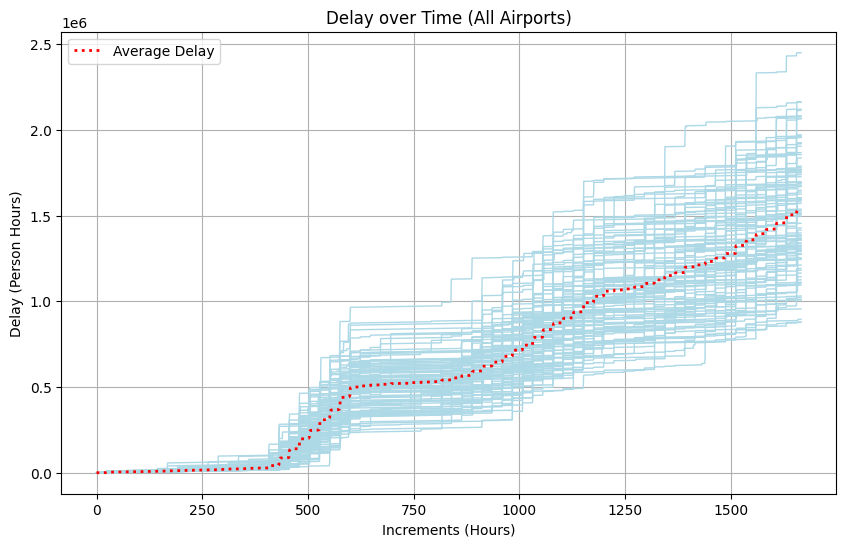

In [11]:
plt.figure(figsize=(10,6))

for i in range(delay_per_realization_df.shape[0]):
    plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (delay_per_realization_df.iloc[i,:].values)/60, color='lightblue', linewidth=1)

avg_delay_per_realization_df = delay_per_realization_df.mean(axis=0)
avg_delay_per_realization_df.to_csv("all_airports_scenario1.csv")
plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (avg_delay_per_realization_df.values)/60, label="Average Delay", color='red', linestyle='dotted', linewidth=2)

plt.title("Delay over Time (All Airports)")
plt.xlabel("Increments (Hours)")
plt.ylabel("Delay (Person Hours)")
plt.legend()
plt.grid()

Average Delay for Toronto

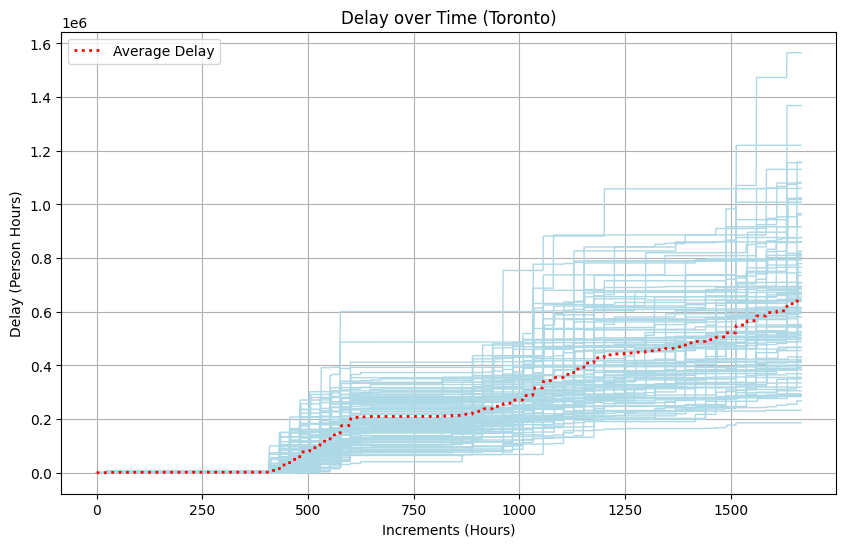

In [12]:
plt.figure(figsize=(10,6))

for i in range(Toronto_delay_per_realization_df.shape[0]):
    plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (Toronto_delay_per_realization_df.iloc[i,:].values)/60, color='lightblue', linewidth=1)

avg_delay_per_realization_df = Toronto_delay_per_realization_df.mean(axis=0)
avg_delay_per_realization_df.to_csv("toronto_original_scenario1.csv")
plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (avg_delay_per_realization_df.values)/60, label="Average Delay", linestyle="dotted", color="red", linewidth=2)

plt.title("Delay over Time (Toronto)")
plt.xlabel("Increments (Hours)")
plt.ylabel("Delay (Person Hours)")
plt.legend()
plt.grid()

Average Delay for Vancouver

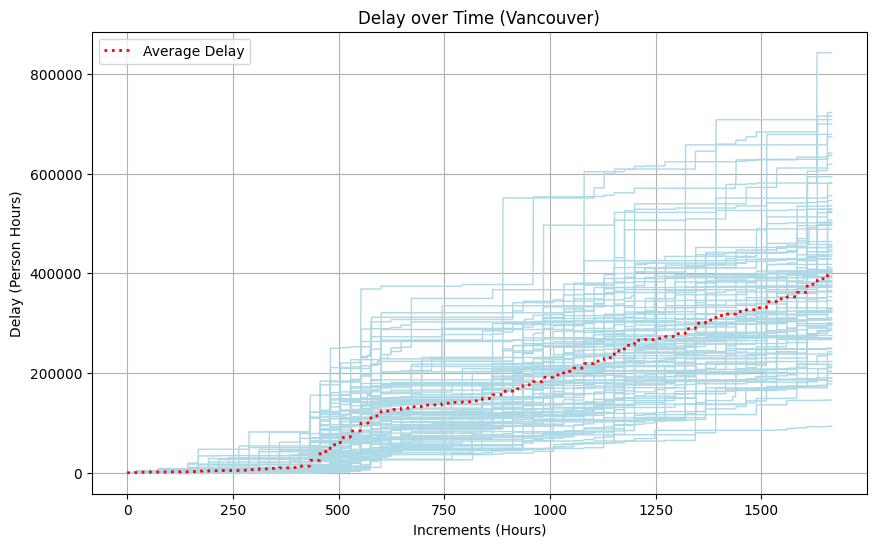

In [13]:
plt.figure(figsize=(10,6))

for i in range(Vancouver_delay_per_realization_df.shape[0]):
    plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (Vancouver_delay_per_realization_df.iloc[i,:].values)/60, color='lightblue', linewidth=1)

avg_delay_per_realization_df = Vancouver_delay_per_realization_df.mean(axis=0)
avg_delay_per_realization_df.to_csv("vancouver_original_scenario1.csv")
plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (avg_delay_per_realization_df.values)/60, label="Average Delay", color='red', linestyle="dotted", linewidth=2)

plt.title("Delay over Time (Vancouver)")
plt.xlabel("Increments (Hours)")
plt.ylabel("Delay (Person Hours)")
plt.legend()
plt.grid()

Average Delay for Montreal

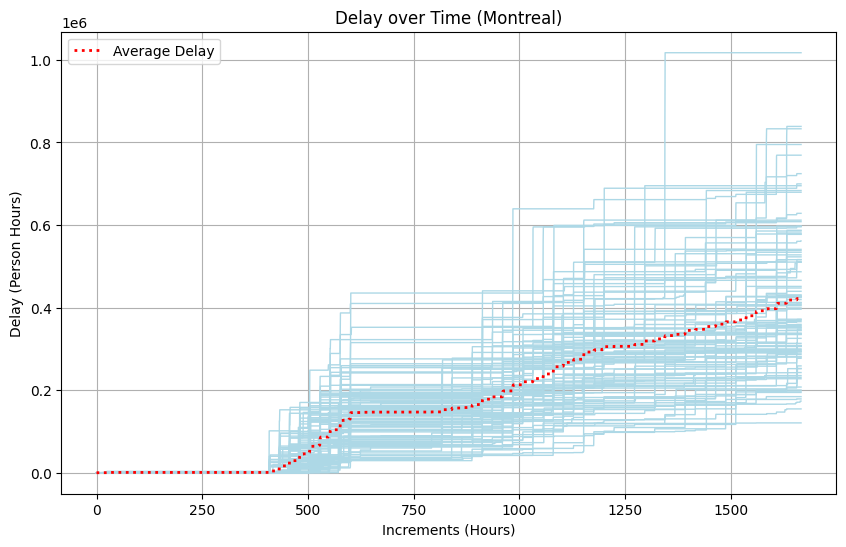

In [14]:
plt.figure(figsize=(10,6))

for i in range(Montreal_delay_per_realization_df.shape[0]):
    plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (Montreal_delay_per_realization_df.iloc[i,:].values)/60, color='lightblue', linewidth=1)

avg_delay_per_realization_df = Montreal_delay_per_realization_df.mean(axis=0)
avg_delay_per_realization_df.to_csv("montreal_original_scenario1.csv")
plt.plot([int(col[10:])/60 for col in delay_per_realization_df.columns], (avg_delay_per_realization_df.values)/60, label="Average Delay", color='red', linestyle='dotted', linewidth=2)

plt.title("Delay over Time (Montreal)")
plt.xlabel("Increments (Hours)")
plt.ylabel("Delay (Person Hours)")
plt.legend()
plt.grid()

Cancellation Plot

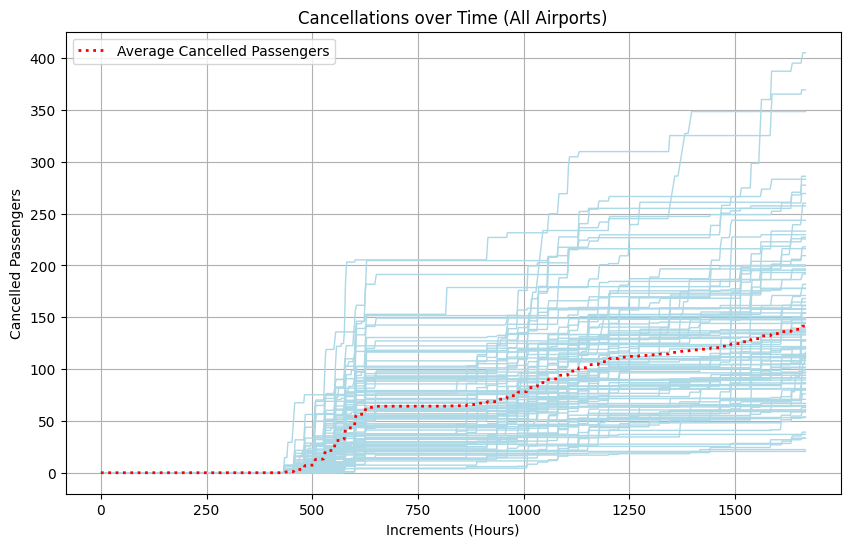

In [15]:
plt.figure(figsize=(10,6))

for i in range(cancellation_delay_per_realization_df.shape[0]):
    plt.plot([int(col[10:])/60 for col in cancellation_delay_per_realization_df.columns], (cancellation_delay_per_realization_df.iloc[i,:].values)/60, color='lightblue', linewidth=1)

avg_delay_per_realization_df = cancellation_delay_per_realization_df.mean(axis=0)
avg_delay_per_realization_df.to_csv("all_airports_scenario1.csv")
plt.plot([int(col[10:])/60 for col in cancellation_delay_per_realization_df.columns], (avg_delay_per_realization_df.values)/60, label="Average Cancelled Passengers", color='red', linestyle='dotted', linewidth=2)

plt.title("Cancellations over Time (All Airports)")
plt.xlabel("Increments (Hours)")
plt.ylabel("Cancelled Passengers")
plt.legend()
plt.grid()